In [60]:
import torch
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(3, 32, (3,3)),
                        nn.MaxPool2d((2,2)),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, (3,3)),
                        nn.MaxPool2d((2,2)),
                        nn.ReLU()
                    )
        
        self.fc = nn.Sequential(
                        nn.Linear(64, 512),
                        nn.ReLU(),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.Linear(128, 10)
                    )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], 64, 6*6).mean(2)
        x = self.fc(x)
        
        return x

In [53]:
x = torch.rand(100, 3, 32, 32)
net = CNN()
y = net(x)
print (y.shape)

torch.Size([100, 10])


In [19]:
def process_dataset(dataset):
    X = []
    y = []
    for i, (k, v) in enumerate(dataset.items()):
        X.append(v)
        y.append([i] * v.shape[0])
    X = np.concatenate(X)
    y = np.concatenate(y)
    X = torch.from_numpy(X).type(torch.float32)
    y = torch.from_numpy(y).type(torch.int64)
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    return dataset, dataloader

In [22]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

cifar_train = datasets.CIFAR10("./dataset/", train=True, download=True, transform=T)
cifar_test = datasets.CIFAR10("./dataset/", train=False, download=True, transform=T)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=256)

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losses.append(loss)
    return losses

In [30]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct * 100

In [54]:
model = CNN()
optimizer = torch.optim.AdamW(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [55]:
epochs = 5
training_losses = []
test_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1} - ", end="")
    train_losses = train(train_loader, model, loss_fn, optimizer)
    test_acc = test(test_loader, model, loss_fn)
    training_losses += train_losses
    test_accuracy.append(test_acc)

Epoch 1 - Test Error: 
 Accuracy: 35.7%, Avg loss: 1.704811 

Epoch 2 - Test Error: 
 Accuracy: 38.8%, Avg loss: 1.616205 

Epoch 3 - Test Error: 
 Accuracy: 44.4%, Avg loss: 1.499332 

Epoch 4 - Test Error: 
 Accuracy: 48.1%, Avg loss: 1.412171 

Epoch 5 - Test Error: 
 Accuracy: 48.7%, Avg loss: 1.383509 



In [65]:
def get_CAM(feature_map, weight, class_idx):
    size_upsample = (32, 32)
    bz, nc, h, w = feature_map.shape

    before_dot = feature_map.reshape((nc, h*w))
    cam = weight[class_idx].unsqueeze(0) @ before_dot

    cam = cam.squeeze(0)
    cam = cam.reshape(h, w)
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)
    cam = torch.clip(cam, 0, 1)
    
    img = transforms.Resize(size_upsample)(cam.unsqueeze(0))
    
    return img.detach().numpy(), cam

In [66]:
cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

def plot_cam(img, cam):
    ''' Visualization function '''
    img = img.permute(1, 2, 0)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,7))
    ax1.imshow(img)
    ax1.set_title(f"Input image\nLabel: {cifar10_classes[y]}")

    ax2.imshow(cam.reshape(32, 32), cmap="jet")
    ax2.set_title("Raw CAM.")

    ax3.imshow(img)
    ax3.imshow(cam.reshape(32, 32), cmap="jet", alpha=0.2)
    ax3.set_title(f"Overlayed CAM.\nPrediction: {cifar10_classes[idx[0]]}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true class:  bird
predicated class:  bird


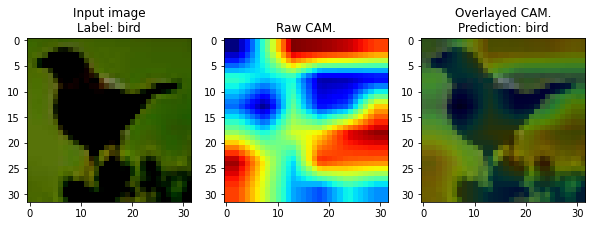

In [68]:
rand_idx = torch.randint(0, 10000, size=[1]) # pick a random index from the test set

x = cifar_test[rand_idx][0] # test image
y = cifar_test[rand_idx][1] # associated test label

model.eval()
scores = model(x.unsqueeze(0)) # get the soft labels
probs = scores.data.squeeze()
probs, idx = probs.sort(0, True)

print('true class: ', cifar10_classes[y])
print('predicated class: ', cifar10_classes[idx[0]])

params = list(model.fc.parameters())
weight = params[0].data

feature_maps = model.conv(x.unsqueeze(0))
heatmap, _ = get_CAM(feature_maps, weight, idx[0])
    
plot_cam(x, heatmap)